# Que hace

El orquestador lo que hace es:
- breaks down tasks into subtasks
- delega subtasks a workers
- sintetiza el output de los workers en un resultado final

# Import

In [26]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langgraph.types import Send
from typing_extensions import TypedDict
from langchain.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

from dotenv import load_dotenv
load_dotenv()

True

# Model, Schemas, State

In [7]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [8]:
llm = init_chat_model(model="gpt-5-nano")

In [9]:
planner = llm.with_structured_output(Sections)

In [15]:
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report: str

In [16]:
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes

In [18]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

In [19]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [20]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

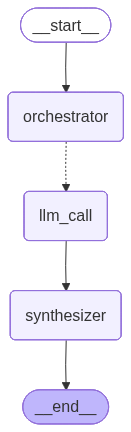

## Executive summary and description

- Overview of scaling laws
  - Model performance generally improves with increases in model size, data volume, and compute, but the gains are non-linear and highly dependent on data quality, task complexity, and training discipline.
  - The dominant drivers of performance are interdependent: larger models often require proportionally more data to realize their potential, while compute limits shape the feasible combinations of size and data.

- How size, data, and compute relate to performance
  - Model size: larger networks can capture more complex patterns, but returns accelerate past certain thresholds only when paired with sufficient data and stable optimization.
  - Data: more high-quality, diverse, and representative data tends to yield stronger generalization and lower perplexity; data quality can outperform sheer quantity when data is noisy or biased.
  - Compute: compute budgets determine the feasible training duration, hyperparameter exploration, and model updates; beyond a point, additional compute yields diminishing returns unless paired with better data or model design.

- Practical implications for project planning
  - Scaling plans should be staged: define milestones aligned with model size and data targets, and reserve budget for data curation, infrastructure, and monitoring.
  - Data strategy matters as much as model choice: invest early in data collection, labeling, and quality assurance to maximize returns from larger models.
  - Alignment with business goals: set measurable performance targets (task penalties, latency, reliability) and plan for governance, safety, and auditing from the outset.

- Budgeting considerations
  - Total cost of ownership includes compute (training and fine-tuning), data acquisition and processing, storage, and ongoing inference costs.
  - Optimal configurations often balance model size with data scale under a fixed compute budget (smaller models with more data can outperform very large models trained on limited data in practical settings).
  - Build-for-purpose investments (domain-specific data, curated datasets, and efficient serving) can yield higher ROI than chasing maximal model size alone.

- Risk management and governance
  - Emergent abilities introduce unpredictability: capabilities can appear suddenly at certain scales, with potential safety, reliability, or ethical implications.
  - Risk controls should include screening for biased data, ensuring privacy, establishing guardrails for content generation, and implementing monitoring for unexpected behavior.
  - Deployment risk: larger models increase potential impact of failures and misuses; plan for rollback, auditing, and fail-safe mechanisms.

- Key caveats
  - Diminishing returns: after a scale threshold, incremental gains shrink; efficiency gains may come from data curation, training stability, or architectural improvements rather than sheer size.
  - Emergent abilities: not all capabilities scale predictably; some useful features may appear only above certain thresholds, while others may remain latent or cause unintended consequences.
  - Transferability and task mismatch: scaling benefits observed on benchmark tasks may not fully translate to real-world applications without careful adaptation and evaluation.
  - Resource and environmental considerations: larger scale models entail higher energy use, longer training times, and broader operational risk; sustainability and governance should be incorporated into planning.

- Takeaway for decision-makers
  - Use scaling laws as a planning compass to allocate resources efficiently, but treat them as guidance rather than guarantees.
  - Prioritize data quality and governance alongside model development.
  - Prepare for uncertainty around emergent capabilities and plan robust risk management, monitoring, and governance frameworks from the start.

---

## Background and terminology

- Core quantities
  - N: the number of trainable parameters in the model.
  - D: the total number of tokens in the training data (pretraining corpus size).
  - C: the compute budget allocated to training, typically expressed in FLOPs or equivalent compute measure.
  - Training steps: the number of gradient updates performed during training (often determined by the product of batch size, steps per epoch, and number of epochs).

- Common performance metrics
  - Loss: the cross-entropy (negative log-likelihood) loss averaged over the evaluation dataset.
  - Perplexity: exp(loss) on a language modeling evaluation set; a lower perplexity indicates better predictive probability assignments to the next-token distribution.
  - Accuracy: the fraction of correct predictions on labeled evaluation tasks (e.g., multiple-choice or classification benchmarks).

- Standard benchmarks
  - GLUE and SuperGLUE: broad natural language understanding benchmarks consisting of multiple tasks.
  - MMLU (Many-shot Multi-task Language Understanding): standardized multi-task evaluation across subjects and difficulty levels.
  - BIG-bench: a large, diverse suite of challenging tasks designed to stress emergent capabilities and reasoning.
  - LAMBADA, PTB, WikiText: language modeling-centric benchmarks emphasizing long-range dependencies and perplexity.
  - Code-related benchmarks (e.g., HumanEval): evaluation of programming tasks and code generation.
  - Additional task suites: reasoning, math, commonsense, and domain-specific benchmarks used to assess generalization and transfer.

- Historical context and foundational results
  - Early scaling studies established that model performance improves with increases in model size (N), data exposure (D), and compute (C), following approximate power-law relationships. These studies demonstrated predictable, though diminishing, gains when scaling one or more dimensions and enabled forecasting of how much data, compute, or parameter growth would be needed to reach target performance.
  - Emergence of emergent capabilities: as models grew, qualitative improvements appeared (e.g., few-shot learning, in-context reasoning) that were not evident at smaller scales, reinforcing the practical value of large-scale pretraining.
  - Data-centric refinements and compute-optimality: subsequent work highlighted the importance of data quality, diversity, and alignment with task distribution. Notably, compute-optimal analyses showed that, under a fixed compute budget, it could be more effective to allocate resources toward increasing data rather than merely enlarging parameter counts, leading to recommendations for data-centric scaling and rebalancing of N and D under C.
  - Ongoing refinements: broader validation across tasks, improved training curricula (e.g., instruction tuning), and alignment techniques further refined the understanding of how scale translates into generalization, robustness, and capabilities across benchmarks.

---

## Empirical scaling laws: core relationships

Across model families and tasks, researchers observe approximate power-law relationships between the resources you allocate (model size, data, compute) and the resulting performance. When plotted on a log-log scale, these relationships appear as straight-line trends over broad ranges, with diminishing returns as you scale up.

Canonical forms (intuitive, practitioner-friendly)
- Performance via a loss-like quantity:
  L(N, D) ≈ L∞ + A N^{−α} + B D^{−β} + C (N D)^{−γ}
  - L∞: irreducible error or limit when resources go to infinity.
  - N: model size (e.g., number of parameters).
  - D: data size (e.g., tokens, examples).
  - α, β, γ > 0: regime- and family-dependent exponents.
  - A, B, C: positive constants capturing task/architecture sensitivity.

- Performance monotonic relation (alternative view):
  P(N, D) ≈ P∞ − [A N^{−α} + B D^{−β} + C (N D)^{−γ}]
  - P∞: asymptotic maximum performance; larger is better.

- Compute-centric perspective (total compute C ∝ N × T, training steps T):
  P(C) ≈ P∞ − κ C^{−δ}
  - δ > 0 captures how quickly performance improves as you invest more compute. δ is regime- and family-dependent and often smaller than exponents on N or D individually.

- Data-quality perspective (effective data size):
  D_eff = q · D, with q ∈ (0, 1] representing data quality (noise, labeling errors, redundancy, domain mismatch).
  L(N, D_eff) ≈ L∞ + A N^{−α} + B D_eff^{−β} + … 
  - Improving data quality is equivalent to increasing D_eff, shifting you along the same scaling curve.

Fixed-data vs fixed-model regimes (intuitive distinctions)
- Fixed-data regime (D fixed, vary N)
  - L(N) ≈ L∞ + A N^{−α}
  - Interpretation: With a fixed dataset, increasing model size yields improvements that scale as a power of N with diminishing returns (α > 0). Early gains are relatively large; incremental gains shrink as N grows.

- Fixed-model regime (N fixed, vary D)
  - L(D) ≈ L∞ + B D^{−β}
  - Interpretation: With a fixed model, gathering more data yields improvements that scale as a power of D with diminishing returns (β > 0). Early data gains can be substantial if the dataset is noisy or underrepresented.

- Mixed regime (scaling both N and D with compute)
  - If you scale both resources together, you often observe roughly additive effects plus a cross-term that captures synergies:
    L(N, D) ≈ L∞ + A N^{−α} + B D^{−β} + C (N D)^{−γ}
  - In practice, the cross-term (N D)^{−γ} is often smaller than the main terms but can matter when both N and D are scaled substantially.

Role of data quality
- Data quality acts as a multiplicative lever on D:
  - Higher-quality data increases D_eff and shifts you to better regions of the same scaling law.
  - Poor data quality (noise, label errors, distribution shift) reduces the effective data signal and flattens the D-exponent (β) in practice.
- Practical implication: marginal gains from more data are larger when data quality is good; improving annotation, curation, and distributional alignment can yield larger exponent gains than raw data quantity in some regimes.

Diminishing returns and regime boundaries
- All exponents (α, β, γ, δ) are typically less than 1, reflecting diminishing returns.
- Early scaling can be steep (larger effective exponents) when moving from tiny models or tiny datasets to modestly larger ones; as you scale further, gains shrink.
- The regime you are in depends on task, architecture, data distribution, and training protocol. For example:
  - In data-rich, capacity-limited regimes (large D, large N), marginal benefits per added parameter or data token tend to shrink more slowly or more quickly depending on data quality and architectural efficiency.
  - In compute-constrained regimes, the balance between model size and training steps becomes crucial; naive scaling of one resource without adjusting the other yields smaller δ and slower improvements.

How exponents vary by regime and model family (guiding intuition)
- Regime dependence
  - Fixed-data: α governs how effectively you can compress knowledge into a larger model. In practice, α tends to be small (often in the ~0.05–0.15 range in large-scale settings), reflecting gradual gains as models grow.
  - Fixed-model: β governs the value of more data. When data quality is high and distribution is aligned, β can be moderate (somewhat larger than α in many benchmarks), but gains saturate as data covers diverse regimes.
  - Mixed/compute-limited: δ captures overall efficiency of compute; δ is typically smaller than the single-resource exponents, reflecting the reality that raw compute growth yields diminishing returns unless it also enables more efficient representations and training dynamics.

- Model family dependence
  - Transformer-based large language models and vision-language models often exhibit robust, broad power-law scaling with both N and D, but with exponents that differ from smaller, non-transformer architectures.
  - Simpler architectures or redundancy-prone data can yield smaller exponents (slower gains) in N or D, while highly optimized, data-efficient architectures can exhibit relatively larger exponents over practical ranges.
  - Data modality and task type matter: language modeling, image modeling, and multimodal tasks may show different effective exponents due to dataset structure, tokenization, and inductive biases.

Practical use: how to leverage these laws
- Budget planning
  - Fit a simple two-term model to pilot data:
    L(N, D) ≈ L∞ + A N^{−α} + B D^{−β}
  - Estimate α and β from small-scale runs varying N and D, then project required N and D to reach a target loss or performance.
- Identify regime
  - If performance improves primarily with N when D is fixed, you’re primarily in a fixed-data regime.
  - If performance improves primarily with D when N is fixed, you’re in a fixed-model regime.
  - If both N and D need to scale for meaningful gains, you’re in a mixed regime and should consider joint scaling with the cross-term if data suggests synergy.
- Data quality guidance
  - Treat data quality as a lever on D_eff; invest in data curation and labeling improvements to shift you to a higher-effective-data regime before costly data collection.
- Cross-family planning
  - Use exponents as rough guides but verify with small-scale experiments in your target domain and architecture.
  - Expect that exponents will shift when moving to a different task, dataset, or architecture; re-fit the scaling model when you change regimes.
- Caution and caveats
  - Real-world data is not i.i.d.; distribution shift, dataset nonstationarity, and evaluation mismatches can break simple power-law fits.
  - Diminishing returns can be steep near architectural or optimization limits (e.g., training stability, memory constraints, or data quality ceilings).
  - Always validate extrapolations with targeted experiments before committing to large-scale scaling.

In short
- The core empirical picture is a set of interlocking power laws linking N, D, compute, and performance, often expressible as L(N, D) ≈ L∞ + A N^{−α} + B D^{−β} (+ a cross-term).
- Fixed-data and fixed-model limits give clean, interpretable forms; data quality and regime shifts modulate effective exponents.
- Exponents vary by regime and by model family; treat them as guidance, not guarantees, and re-estimate in the target domain as you scale.

---

## Data, compute, and model trade-offs: planning with scaling laws

Scaling laws describe how model size (N), data size (D), and compute (C) interact to determine achieved performance on a target capability. In practice these laws provide a quantitative framework to allocate resources efficiently: given a target task and a fixed or limited compute budget, how should you balance larger models vs more data and more optimization steps to maximize expected capability?

Key ideas to keep in mind
- Performance tends to improve with larger N and larger D, but with diminishing returns. The gains from increasing one dimension depend on the levels of the others.
- Scaling laws are often expressed as simple surrogate relationships, such as a loss L that decreases as a function of N and D (and training steps or compute), e.g., L ∝ N^(-α) D^(-β) E^(-γ) under certain regimes. The actual exponents α, β, γ must be derived from literature or calibrated to internal data; they capture the relative data efficiency and parameter efficiency of your setting.
- The Chinchilla principle (a practical takeaway from the literature) states that, for a fixed compute budget, allocating more effort to data (D) and using a smaller model (N) can yield better final performance than using a larger model with less data, assuming data quality is comparable. This does not imply data quality is irrelevant; rather, it highlights where effort yields the most performance per compute unit under many common regimes.

Practical workflow to plan with scaling laws

1) Define the target capability and success metric
- Specify the task or suite of tasks (e.g., code understanding, multilingual translation, reasoning on a benchmark) and a clear, quantitative target (e.g., target loss, accuracy, or an API-level capability score).
- Establish a credible budget for compute, data acquisition, and engineering time. Document any non-negotiables (data restrictions, latency targets, hardware constraints).

2) Gather literature-derived curves and priors
- Collect published scaling curves that relate performance (or loss) to N, D, and compute for similar model families and tasks. Typical sources include language modeling and vision papers that report how loss scales with model size and data tokens under fixed compute budgets.
- Collect or build priors for reasonable ranges of exponents (α for N, β for D, γ for compute/epochs). If direct regression is not feasible, adopt commonly reported regimes (e.g., regimes where data becomes the limiting factor vs. compute limiting) as starting points.
- Where possible, assemble internal data from past projects (e.g., performance vs parameters and data at various training scales) to tailor priors to your domain and data quality.

3) Fit or adopt scaling exponents
- Fit a simple surrogate model to the collected curves. A common starting form is a loss surrogate L ≈ c × N^(−α) × D^(−β) × E^(−γ), with E representing effective training effort (epochs, steps, or token throughput) and c a constant.
- If fitting is not feasible, adopt literature-extracted exponents for similar regimes and adjust with a small calibration using a pilot run or historical data.
- Validate the surrogate by checking that it reasonably tracks known points (e.g., mid-scale experiments) before using it for planning.

4) Perform scenario analysis (resource allocations under a budget)
- Establish a budget constraint for compute and data. A simplified surrogate for planning purposes is:
  Compute_budget ∝ N × D × E (with a constant of proportionality reflecting hardware efficiency and per-step cost). In practice, calibrate this constant to your infrastructure.
- Define a grid of candidate (N, D, E) combinations that satisfy the budget constraint.
- For each candidate, predict the target capability using your surrogate model. Rank options by predicted performance, while also considering risk (e.g., data quality, training stability) and practical constraints (data availability, data cleaning time, training stability with very small models on very large datasets).
- Use the ranking to identify a handful of flagship configurations to explore in real experiments (ideally 2–4).

5) Translate targets into concrete N, D, and training steps
- From the chosen configuration(s), translate to concrete numbers:
  - N: number of trainable parameters (e.g., model architecture size, layer widths, depth).
  - D: total tokens or data examples to be used for training (and a plan for data curation, cleaning, and labeling if needed).
  - E (training steps/epochs): total optimization steps or passes over the dataset; include planned learning rate schedule and checkpoint cadence.
- Ensure that the proposed plan respects practical constraints:
  - Data quality and diversity: ensure gains from more data are realizable with clean, representative data.
  - Training stability: very large data volumes with tiny models can require careful optimization (lr warmups, gradient clipping, regularization).
  - Latency and deployment goals: larger models may not meet latency targets even if accuracy is higher; consider model compression or distillation as a complementary lever.

6) Validate, iterate, and hedge risk
- Run a controlled pilot to verify that the surrogate predictions hold at the chosen scale. Compare predicted performance to actual performance and adjust exponents or constants as needed.
- Plan iterations: define a staged rollout where you first validate the middle tier of N and D, then scale up or pivot toward more data or larger models depending on results and evolving constraints.
- Build in guardrails for data issues (quality, leakage) and for compute overruns (budget, hardware availability).

Key insights and practical implications

- The Chinchilla principle as a planning guide: for a given compute budget, prioritize data and train smaller models if data quality is solid. This often yields higher final capability than allocating the same compute to larger models with less data. The implication is a bias toward data collection, cleaning, and efficient data pipelines in the early planning phases, particularly when data quality is the primary driver of task performance.
- Diminishing returns and regime dependence: the relative value of increasing N vs D depends on the current regime (data-rich vs data-poor, compute-limited vs data-limited, task difficulty). Use scaling curves to identify the regime you are in and allocate resources accordingly.
- Practical surrogate models are powerful planning tools but require calibration: start with published exponents and calibrate using internal data if possible. Use simple, transparent surrogates to keep the planning loop interpretable and auditable.
- Data strategy matters: increasing data quantity is only beneficial if data quality, diversity, and relevance align with the target capability. Data curation, annotation quality, and representation of edge cases often drive the realized gains, sometimes more than raw data volume.
- Risk-aware optimization: while the surrogate guides ideal allocations, real-world constraints (data access, labeling cost, hardware reliability, software stack maturity) should shape final decisions. Include fallback options (e.g., distillation, sparsity, or architectural tweaks) as part of the plan.

Notes and caveats

- Scaling laws provide guidance, not guarantees. They describe average trends across large regimes; individual tasks and data distributions can diverge.
- Always plane for data quality and distributional shift. The same scaling law that says “more data helps” assumes data quality remains high; degradation in data quality can reverse expected gains.
- When reporting plans, document the assumed exponents and the calibration data used. This aids reproducibility and future updates as you collect more internal evidence.

In summary, scaling laws offer a disciplined way to map a target capability to an allocation of N, D, and training steps under a compute budget. The Chinchilla principle is a practical reminder to weigh data-centric strategies more heavily when compute is constrained, while acknowledging that the optimal mix is task- and data-dependent and should be validated with iterative experiments.

---

## Emergent abilities and scaling thresholds

Emergent abilities are capabilities that do not appear at smaller scales but arise once a system crosses certain scale thresholds in parameters, data, compute, or architectural complexity. These shifts often resemble phase transitions: gradual accumulation of capacity becomes a sudden, qualitative change in what the system can do. Understanding and anticipating these thresholds is essential, because they can unlock powerful new behaviors while also introducing unforeseen risks.

- How thresholds manifest
  - Qualitative leaps in capability: tasks that were previously infeasible become tractable once the model reaches a critical size or training regime.
  - New competencies across domains: multi-step reasoning, planning, tool use, long-horizon memory, or meta-learning-like behaviors may emerge only after surpassing specific scales.
  - Nonlinear performance curves: improvements are not strictly linear with size or data; small increases can yield outsized gains once the threshold is crossed.

- Why this matters for extrapolation and planning
  - Extrapolation is uncertain: predicting what a model will do beyond current scale is inherently unreliable if emergent behavior could appear abruptly.
  - Phase-transition-like dynamics complicate risk assessment: new abilities can introduce both opportunities and novel failure modes that were not present at smaller scales.
  - Dependence on context: thresholds depend on data quality, training objectives, architecture, and optimization dynamics, making universal predictions difficult.

- Implications for risk and governance
  - Unknown capabilities: emergent abilities may enable actions or reasoning that were not anticipated, raising alignment, safety, and misuse concerns.
  - Evaluation gaps: standard benchmarks may miss emergent capabilities; continuous, diverse testing becomes necessary to detect new behaviors.
  - Containment challenges: once a capability appears, it can be hard to constrain or revert without affecting other aspects of performance.

- Implications for project planning and roadmapping
  - Plan with uncertainty: build option-like milestones triggered by observed thresholds, not just fixed timelines or metrics.
  - Incremental gating: deploy capabilities in stages with increasing oversight, safety controls, and risk budgets as thresholds approach or are crossed.
  - Resource allocation under uncertainty: allocate reserve compute and evaluation capacity to study potential emergent behaviors rather than only pursuing known tasks.
  - Cross-disciplinary review: involve safety, ethics, legal, and domain experts early to anticipate domain-specific emergence risks.

- Practical strategies to manage emergence
  - Capability monitoring: track signals across tasks that are known to correlate with emergent abilities (e.g., multi-step reasoning, tool use, long-horizon planning, zero-shot adaptation).
  - Scenario-based planning: develop and test qualitative scenarios for potential threshold-crossing capabilities and their implications.
  - Guardrails and containment: implement modular architectures, tool-use restrictions, audit trails, and kill-switch mechanisms that can be engaged if unexpected abilities arise.
  - Iterative risk assessment: update risk models as new thresholds are observed, incorporating real-world deployment data and adversarial testing results.

- Indicators and signals to watch
  - Sudden improvements on tasks requiring planning, abstraction, or cross-domain inference without additional changes to data or objectives.
  - Emergence of multi-modal or tool-use behaviors (e.g., chaining actions, using external resources) in previously non-tool-using systems.
  - Shifts in failure modes under stress or distribution shift that reveal new capabilities or weaknesses.
  - Changes in adaptability to novel tasks with little or no task-specific tuning.

- cautions for interpretation
  - Not all scale increases yield useful emergent abilities; some thresholds may be context-specific or fragile.
  - Emergent abilities can coexist with brittle or unreliable behavior in other areas, creating a mixed-capability profile.
  - The timing of threshold crossing is inherently uncertain; planning should assume a range of possible trajectories rather than a single forecast.

- Concrete takeaway
  - Treat scaling thresholds as a fundamental uncertainty in capability development. Build adaptive plans that anticipate abrupt capability changes, prioritize robust evaluation, and implement governance that can respond quickly to new emergent behaviors while maintaining safety and alignment goals.

---

### Data quality, curriculum, and training efficiency

Data quality, representativeness, and curation interact deeply with scaling laws to determine how efficiently a model can learn and generalize. In practice, the quality and composition of the data often set the ceiling for what scale alone can achieve. This section outlines how data quality and curation influence the effectiveness of scaling, how curriculum strategies can be leveraged to improve generalization and sample efficiency, and how distribution shifts alter the value of different data regimes.

1) Data quality and scaling laws
- Noise and labeling accuracy: Label noise reduces signal strength, slows learning, and degrades generalization. The impact of noise generally scales with model size and data volume: larger models can tolerate higher noise levels up to a point, but beyond that point, noise flattens gains from scaling and worsens calibration and robustness.
- Data cleaning vs. data quantity: Dreshing and curating data (noise reduction, correction of systematic errors, removing near-duplicates) often yields larger performance gains per example than simply adding more data with the same quality. In other words, data-centric improvements can shift the marginal returns predicted by scaling laws.
- Signal quality and label provenance: High-quality annotations, clear task definitions, and consistent labeling conventions increase the effective sample quality, thereby improving generalization at a given data budget.

2) Representativeness, distribution shifts, and scaling
- Representativeness matters more as you scale: If the training distribution diverges from deployment distribution, the benefits of more data diminish unless the data covers the target domain or the model can adapt. Scaling laws assume i.i.d. data; domain shifts violate that assumption and can cause performance plateaus or regressions.
- Covariate and concept shifts: Shifts in input distributions (covariate shift) or in the mapping from inputs to labels (concept shift) reduce sample efficiency. Robustness to shifts often requires either data augmentation, domain-aware curricula, or explicit domain adaptation strategies, which interact with data quality.
- Long-tail and underrepresented regions: Scaling alone may not fix poor coverage of rare cases. Curated inclusion of diverse subpopulations, edge cases, and difficult examples becomes crucial to preserve generalization as models grow.

3) Curriculum strategies and learning order
- Easy-to-hard progression: Curriculum learning starts with simpler, high-signal examples and gradually introduces complexity or harder distributions. This can accelerate early convergence and improve final generalization, especially when data quality varies or noise is present.
- Self-paced and adaptive curricula: Weights or sampling probabilities can be adjusted as the model trains, guided by current loss, uncertainty, or gradient signals. In non-stationary settings, curricula can adapt to drift by reprioritizing data sources that align with the current model deficiency.
- Data-centric curricula and dynamic augmentation: Combining curricular ordering with data augmentation and perturbation strategies allows the model to build robust representations before encountering the most challenging or shift-affected samples.
- Active learning with curriculum constraints: Active querying of informative, underrepresented, or mislabeled examples can be structured as a curriculum: select easy, then progressively harder, or select samples that expose current model weaknesses in a controlled way.

4) Data curation, valuation, and governance
- Filtering and deduplication: Removing ambiguous, low-quality, or near-duplicate data improves effective data quality more than marginal gains from raw data expansion.
- Balancing and stratification: Addressing class or domain imbalances helps ensure that scaling benefits do not come at the expense of underrepresented groups or domains.
- Data valuation: Estimating the marginal value of individual examples (e.g., data Shapley-like metrics, influence scores) can guide curation priorities, labeling efforts, and active data acquisition. When resources are limited, valuing data helps allocate effort where it yields the greatest gains in generalization and sample efficiency.
- Provenance and labeling policy: Clear documentation of data sources, labeling guidelines, and quality controls reduces drift and helps maintain performance as data scales.

5) Implications for generalization and sample efficiency
- Generalization under high-quality data: With high-quality data and a well-designed curriculum, models can achieve strong generalization with fewer examples, which shifts the practical scaling curve toward improved data efficiency.
- Robustness to shifts through curriculum and curation: Combining curricula with representativeness-aware data selection and domain-adaptive augmentation improves resilience to distribution shifts, preserving performance while reducing the need for indiscriminate data expansion.
- Long-tail performance: Curated inclusion of rare but representative cases, coupled with curricula that gradually expose the model to long-tail distributions, supports better out-of-distribution and domain-general performance without a linear increase in data volume.

6) Practical guidelines for teams
- Audit data quality early: Measure label noise, annotation consistency, and provenance. Use lightweight QC loops to identify high-error sources and prioritize cleaning efforts.
- Assess representativeness: Compare training distribution to deployment targets. Identify gaps in domains, subpopulations, and edge cases; plan targeted data collection or augmentation to fill those gaps.
- Implement a data-centric curriculum: Start with high-signal, easy examples, then gradually introduce complexity and distribution shifts. Use adaptive schedules tied to model performance signals.
- Combine curriculum with data valuation: Use data importance metrics to guide which samples receive additional labeling, curation, or augmentation, especially when resources are limited.
- Monitor drift and adapt: In non-stationary environments, continuously evaluate model performance across domains and adjust curricula, augmentation, and sampling strategies to maintain efficiency.
- Balance efficiency with fairness and safety: Ensure that curriculum and data curation do not systematically underrepresent or misrepresent important subgroups, and maintain appropriate safeguards for harmful or biased content.

7) Challenges and opportunities
- Measuring data value at scale remains costly. Efficient proxies and scalable valuation methods are needed to guide curation decisions.
- Designing curricula for streaming data and continuous deployment presents practical difficulties, including rapid drift and resource constraints.
- Aligning data quality improvements with scaling objectives requires careful experimentation to avoid diminishing returns or unintended biases.

In summary, data quality, representativeness, and curation fundamentally shape how scaling laws translate into real-world performance. Curriculum strategies, when thoughtfully integrated with data valuation and domain-aware curation, can enhance generalization and sample efficiency, especially in the presence of distribution shifts. A data-centric approach—prioritizing quality, coverage, and adaptive learning order—often yields larger gains than scaling alone and helps sustain robust performance as models and data continue to grow.

---

## Training dynamics, optimization, and system considerations

### Overview of optimization choices
- Optimizers
  - SGD with momentum: robust baseline, strong generalization with well-tuned learning rate and schedule; tends to require careful learning rate warmup for stability.
  - Adam/AdamW: adaptive per-parameter updates, convenient for sparse/heterogeneous gradients; AdamW decouples weight decay for better regularization in large models.
  - LAMB/LARS: enable stable large-batch training by scaling updates with layer-wise norms; useful when data throughput is the bottleneck.
  - AdaFactor, RMSProp variants: memory-efficient options for very large models at the cost of some convergence nuance.
- Learning rate schedules
  - Constant or step decay: simple baselines, often insufficient for long training runs or very large batches.
  - Linear warmup followed by cosine or polynomial decay: widely used for stability in early steps and gradual convergence; helps mitigate large-step instability.
  - 1cycle and cyclic schedules: can improve exploration early in training and reuse of capacity; sensitive to cycle length and temperature.
  - Schedule considerations: larger batch sizes typically require higher initial learning rates with warmup, and either slower decay or custom scaling; schedules should be aligned with data throughput and optimizer choice.
- Regularization and ancillary choices
  - Weight decay, dropout, label smoothing, stochastic depth: moderate regularization can improve generalization; interact with optimizer choice and learning rate.
  - Gradient clipping: stabilizes training for aggressive optimizers or large models; choose norm or value-based thresholds to balance stability and gradient signal.

### Hyperparameter sensitivity
- Key hyperparameters
  - Learning rate, batch size, weight decay, dropout rates, gradient clipping thresholds, and optimizer-specific parameters (beta1, beta2, epsilon, etc.).
- Sensitivity patterns
  - Large models exhibit strong LR sensitivity; small changes can markedly affect convergence speed and final accuracy.
  - Batch size interacts with LR (linear scaling rules are helpful but not universal); large batch regimes often require LR warmup and possibly more aggressive regularization.
  - Regularization interacts with data quality and augmentation; insufficient augmentation can lead to overfitting, while excessive augmentation can hinder convergence.
- Hyperparameter search and automation
  - Bayesian optimization, hyperband/ASHAs, population-based training, and early-stopping-based tuning are practical for high-dimensional spaces.
  - Use progressive scaling: first validate optimization choices on a smaller proxy model or subset of data, then scale to full size.
  - Logging and monitoring: track gradient norms, LR warmup progress, memory usage, and throughput to guide tuning decisions.

### Practical system factors
- Parallelism
  - Data parallelism: simplest and most scalable for moderate model sizes; requires efficient all-reduce to synchronize gradients.
  - Model parallelism (tensor and pipeline): necessary for very large models that do not fit on a single device; tensor (Megatron-style) splits tensor shapes; pipeline splits layers across stages with careful scheduling to minimize bubbles.
  - Hybrid approaches: combine data, tensor, and pipeline parallelism to maximize throughput while balancing memory and communication costs.
- Memory considerations
  - Activation and gradient memory: mixed precision (FP16/BFloat16) reduces memory; optimizer state (especially for Adam-like optimizers) can dominate memory.
  - Memory-saving techniques: gradient checkpointing (recompute activations on the fly instead of storing them); activation offloading; operator fusion and memory pool tuning.
  - Memory footprint planning: account for model parameters, optimizer states, activations, and any auxiliary buffers required by parallelism strategy.
- Throughput and scheduling
  - Communication overhead: all-reduce, all-gather, and model-parallel boundary data transfers are critical bottlenecks; overlapping communication with computation reduces stalls.
  - Pipeline and micro-batching: in pipeline parallelism, choose stage granularity and micro-batch size to balance throughput and stalling; dynamic scheduling can mitigate idle times.
  - Hardware utilization: ensure device and interconnect bandwidth are not underutilized; align data loading, preprocessing, and compute to avoid GPU idle time.
- Fault tolerance and resilience
  - Checkpointing strategy: frequency and granularity trade-off between recovery time and overhead; asynchronous vs synchronous checkpointing affects training speed and determinism.
  - Failure handling: rapid resume from checkpoints, robust job management, and graceful degradation (e.g., partial re-training of affected components) are important for long-running pretraining runs.

### Efficiency techniques and their interplay with scaling
- Gradient checkpointing
  - What it does: trades computation for memory by re-computing some activations during backpropagation instead of storing all intermediates.
  - When to use: essential for deep or very wide networks where memory is the bottleneck; particularly beneficial with very large batch sizes that would otherwise exceed memory.
  - Tradeoffs and guidance: choose checkpoint granularity to balance recomputation overhead with memory savings; deeper networks yield larger savings; compatibility with mixed-precision and certain custom layers must be validated.
  - Interaction with scaling: enables larger models to fit in the same hardware by lowering memory, enabling broader experiments and larger batch regimes; can slightly slow training throughput due to recomputation but often worthwhile as model size grows.
- Model parallelism
  - What it does: splits a model across multiple devices to overcome single-device memory limits; enables training of models that would not fit otherwise.
  - Approaches: tensor (split tensors across devices), pipeline (stages of layers across devices), or hybrid combinations; careful partitioning to minimize cross-device communication and pipeline bubbles.
  - Tradeoffs and guidance: introduces communication overhead and scheduling complexity; monitor for load imbalance and boundary inefficiencies; combine with gradient checkpointing to reduce memory pressure further.
  - Interaction with scaling: as model size grows beyond single-device capacity, model parallelism becomes essential; proper orchestration with data parallelism (hybrid schemes) yields scalable throughput and manageable memory footprints.
- Mixtures of Experts (MoE)
  - What it does: increases parameter count dramatically while keeping per-token computation and memory footprint roughly constant by routing tokens to a sparse subset of experts.
  - Benefits: can dramatically improve model capacity and performance without linearly increasing per-step memory usage; beneficial for very large models and language tasks with diverse data.
  - Challenges: load balancing across experts; routing cost and latency; potential training instability and capacity planning; gating network design impacts sparsity and convergence; deployment and inference require careful consideration of expert availability.
  - Interaction with scaling: MoE aligns well with scaling laws by decoupling parameter growth from per-step memory, enabling extremely large models with feasible hardware utilization; however, scaling MoE also increases complexity in communication, routing, and fault tolerance, so infrastructure and monitoring must scale accordingly.
- Interplay with scaling considerations
  - Scaling laws guide where optimizations have the most impact: as models grow, memory and communication become the primary bottlenecks; MoE and model/parallels help alleviate these constraints.
  - Optimizer and LR schedule tuning become more nuanced with scale due to changes in gradient noise, effective batch size, and synchronization costs; scheduling must balance rapid convergence with stability.
  - Data vs compute balance shifts with scale: at very large scales, data pipelines and throughput often constrain progress more than raw compute, making hardware-aware optimizations (mixed precision, memory savings, and efficient interconnects) crucial.
  - Practical guidance for scaling
    - Start with a solid, memory-conscious baseline (e.g., AdamW with linear warmup and cosine decay; mixed precision; data parallelism).
    - Introduce model parallelism or MoE when model size exceeds device memory; assess communication patterns and load balancing early.
    - Employ gradient checkpointing and memory-saving techniques as model size grows; tune checkpointing depth with compute budget.
    - Use profiling to identify bottlenecks (memory, compute, or communication) and iterate on parallelism strategy and data pipeline optimizations.
    - Plan fault tolerance and checkpointing cadence upfront for long-running training, ensuring fast recovery with minimal downtime.

This section provides a cohesive view of how optimization choices, hyperparameter sensitivity, and practical system factors interact with each other, and how efficiency techniques like gradient checkpointing, model parallelism, and mixtures of experts scale with model size and throughput demands.

---

## Evaluation, benchmarks, and measurement practices

Robust evaluation is essential to credible claims about model performance. This section outlines evaluation protocols, benchmark selection, measurement practices, and safeguards to prevent misinterpretation when moving beyond tested domains. It emphasizes reproducibility, prevention of data leakage, and rigorous cross-domain validation as core requirements.

- Evaluation protocols
  - Define clear success criteria and target metrics aligned with real-world goals (e.g., accuracy, precision/recall, calibration, latency, energy use).
  - Use appropriate data splits: train, validation, and test sets with strict separation; consider time-based or streaming splits to mirror deployment conditions.
  - Prevent data leakage at all stages: ensure preprocessing, feature extraction, and hyperparameter tuning use only training/validation data from the proper splits.
  - Pre-register the evaluation plan when possible: specify metrics, baselines, statistical tests, and run counts in advance.
  - Include nested or stratified cross-validation where applicable to obtain stable estimates for hyperparameters and performance.
  - Report uncertainty: provide confidence intervals or standard errors computed from multiple runs with different seeds and/or bootstrap methods.
  - Document experimental goals and scope clearly to avoid overclaiming beyond what the data supports.

- Benchmarks and benchmark design
  - Select benchmarks that reflect the intended deployment domains, including representative task varieties and input distributions.
  - Favor benchmarks with established baselines and clear, reproducible evaluation protocols; ensure data licenses and access permissions are compatible with sharing.
  - Use diverse and representative benchmark subsets to avoid overfitting to a single dataset.
  - Include both strong baselines and simple baselines to contextualize gains.
  - Consider resource-related benchmarks (latency, memory, compute cost) in addition to accuracy or other task-specific metrics.
  - Assess fairness and bias-related aspects where relevant (e.g., performance across demographic groups, demographic representation in data).
  - Maintain transparency about benchmark construction: data provenance, splits, preprocessing steps, and any augmentations.

- Measurement practices and reporting
  - Choose metrics appropriate to the task and interpret them correctly (e.g., AUROC for imbalanced classification, calibration errors for probability outputs, BLEU/ROUGE for text generation, MSE for regression).
  - Evaluate both absolute performance and relative improvements over baselines.
  - Report per-domain or per-subgroup results alongside aggregated metrics to reveal distributional robustness.
  - Assess calibration and uncertainty: reliability diagrams, Brier score, predictive intervals, and uncertainty quantification methods.
  - Measure robustness and stability: sensitivity to input perturbations, distribution shifts, and adversarial or stress tests.
  - Document all aspects of the experimental setup: random seeds, software versions, hardware, libraries, and any non-deterministic operations.
  - Provide reproducible artifacts: source code, data processing scripts, exact data splits, and environment snapshots (container images or environment specifications).
  - Include error analyses to identify common failure modes and potential biases.

- Reproducibility, data leakage prevention, and cross-domain validation
  - Reproducibility
    - Fix seeds where possible and report them; use deterministic operations when feasible.
    - Capture and share data processing pipelines and model training scripts; version data when permissible.
    - Use containerization or environment spec files to reproduce software stacks; maintain a record of dependencies.
    - Share code and, where allowed, data or precise data access instructions to enable independent replication.
  - Data leakage prevention
    - Ensure no leakage between train/validation/test sets, including leakage through preprocessing steps (e.g., normalization computed on full data).
    - Guard against leakage from hyperparameter tuning into test evaluation; use nested validation for hyperparameter selection.
    - Be cautious of leakage via derived features, external databases, or leakage introduced by data augmentation that uses test or future information.
  - Cross-domain validation
    - Validate performance across multiple, distinct domains or distribution shifts that resemble real-world variability.
    - Include out-of-domain tests or stress tests to gauge generalization beyond the training distribution.
    - Report the extent of domain shift and analyze performance degradation patterns; consider domain adaptation or robust training approaches if substantial drop-offs occur.

- Risks of misinterpretation when extrapolating beyond tested domains
  - Distribution shift and covariate shift can invalidate benchmark-level conclusions; performance gains may not transfer to new domains.
  - Models optimized for a benchmark may exploit dataset-specific quirks rather than generalizable patterns (benchmark overfitting).
  - Extrapolated claims should be bounded and qualified with explicit caveats about domain similarity, data distribution, and deployment conditions.
  - Hidden biases in datasets can lead to misleading conclusions about overall capabilities or fairness in broader contexts.
  - Mitigations
    - Conduct explicit out-of-domain or cross-domain evaluations and report results transparently.
    - Present calibrated expectations with clear limitations and avoid overgeneralization.
    - Use stress tests and scenario-based evaluations to reveal potential failure modes in new settings.
    - Encourage independent replication and external benchmarks to corroborate findings.

- Practices to ensure credible results
  - Pre-registration and preregistered analysis plans to deter post hoc cherry-picking.
  - Independent replication or audits when possible; encourage open code, data, and pre-trained model access.
  - Comprehensive documentation of experimental setup, including data sources, preprocessing, hyperparameters, and training regimes.
  - Transparent data provenance and licensing; clearly state data restrictions and usage rights.
  - Robust experiment tracking and lineage (experiment IDs, versioning, and changelogs) to facilitate traceability.
  - Ethical and privacy considerations, including data handling, consent, and mitigation of harms or bias.
  - Clear, structured reporting that separates results by domain, dataset, and condition, with explicit limitations.

- Suggested deliverables and reporting checklist
  - Documented evaluation plan with chosen metrics and baselines.
  - Detailed data splits, preprocessing steps, and data provenance.
  - Reproducible codebase, model weights, and environment specifications.
  - Results with confidence intervals, per-domain breakdowns, and robustness analyses.
  - Discussion of limitations, potential biases, and extrapolation caveats.
  - Availability of independent replication materials or third-party evaluation where feasible.

- Practical examples of robust evaluation
  - A model evaluated on multiple, well-documented benchmarks plus an out-of-domain test set; results reported with confidence intervals and baseline comparisons.
  - A calibration study showing reliability diagrams and Brier scores, alongside decision-making impact analyses.
  - A cross-domain study assessing performance under simulated distribution shifts and documenting degradation patterns and mitigation strategies.

This framework aims to foster credible, transparent, and reproducible evaluation practices that support reliable interpretation, honest reporting of limitations, and robust deployment decisions across domains.

---

# Case studies and real-world examples

- GPT-3 (175B parameters)

  - What scaling looked like in practice: Scaling from prior models to GPT-3 involved a dramatic increase in both parameter count and training data, enabling robust zero-shot and few-shot capabilities and emergent abilities that were not present in smaller models.
  - What theory predicted: Scaling laws suggested that, in general, loss should decrease as model size and data (and compute) increase, with diminishing returns but predictable trends. The idea of computing-optimal allocations implied tradeoffs between model size and data under a fixed compute budget.
  - What emerged: GPT-3 validated many scaling intuitions: larger models trained on vast data substantially improve performance across a wide range of tasks, and surprisingly capable zero-shot and few-shot generalization emerges at scale. Some capabilities appeared abruptly at certain scales, consistent with emergent behavior predicted by scaling theories.
  - Lessons for future work: Scaling alone yields meaningful gains, but there are diminishing returns and hardware/computation constraints. Prompt design and data diversity become critical with scale, and emergent capabilities suggest investing in evaluation regimes that probe generalization and reasoning across tasks.

- PaLM (540B parameters)

  - What scaling looked like in practice: PaLM pushed to very large parameter counts with extensive training data to push multilingual and reasoning capabilities, enabling impressive performance on a broad set of tasks.
  - What theory predicted: Scaling laws anticipated continued gains with larger models and more data, with cross-linguistic performance improving as data coverage widened. Emergent reasoning capabilities were expected to arise with scale.
  - What emerged: PaLM demonstrated notable improvements in multilingual understanding, code-related tasks, and complex reasoning. It also highlighted the value of prompting techniques (and its own experiments with chain-of-thought prompting) to unlock reasoning capabilities that scale can enable.
  - Lessons for future work: The payoff to scale remains substantial but comes with steep compute costs. Beyond raw scale, data quality, distributional coverage (especially multilingual data), and clever prompting/finetuning strategies (e.g., chain-of-thought) play crucial roles in unlocking higher-order abilities.

- Chinchilla (compute-optimal scaling: smaller model with more data)

  - What scaling looked like in practice: The study argued for a compute-optimal balance between model size and data—rather than simply enlarging parameters, allocate more compute to data and training steps for a smaller model.
  - What theory predicted: Scaling laws indicate there is an optimal mix of parameters and data for a given compute budget. Data scale can drive most of the gains when the model size is set near that optimum.
  - What emerged: Under compute-constrained conditions, a smaller model (e.g., around tens of billions of parameters) trained on far more data achieved competitive or superior performance to much larger models trained on comparatively less data. This validated the idea that data abundance can compensate for fewer parameters when compute is fixed.
  - Lessons for future work: For budget-conscious deployments, prioritize data quantity and diversity alongside efficient model design. This challenges the assumption that endlessly larger models are always best and highlights the importance of compute-aware planning and data curation.

- LLaMA (7B–65B parameter range)

  - What scaling looked like in practice: LLaMA explored a broad spectrum of sizes with a focus on performance across tasks and languages, emphasizing accessibility through more widely available weights.
  - What theory predicted: Scaling laws would continue to show improvements with increasing parameters and data, while efficiency (i.e., better data usage and training practices) could yield strong results even at smaller sizes.
  - What emerged: LLaMA achieved strong performance across standard benchmarks and multilingual tasks, with the mid-to-large sized models offering a favorable balance of accuracy, efficiency, and accessibility. Open weights enabled broader evaluation and replication, accelerating collective progress.
  - Lessons for future work: Open, well-documented weights and diverse training data enable broader research and scrutiny, helping validate scaling predictions across communities. Data quality and multilingual coverage are critical levers for real-world applicability.

- Cross-cutting lessons across cases

  - Scaling laws broadly held in practice but with caveats: Observed gains generally followed the spirit of power-law trends, including notable emergent abilities at larger scales, but exact trajectories depended on data quality, distribution, and training regimens.
  - Compute allocation matters: For a fixed compute budget, there is a meaningful trade-off between model size and data. The Chinchilla findings emphasize that data quantity and quality can be as important as parameter count for maximizing performance under compute constraints.
  - Data quality and diversity are critical: Across cases, richer, more diverse, and higher-quality data often drove more significant improvements than merely increasing parameters.
  - Emergence and task breadth: Larger models tend to exhibit abilities beyond their explicit training signals, including reasoning and generalization capabilities. This underscores the importance of broad evaluation suites and robust prompting strategies.
  - Practical considerations for deployment: Inference latency, cost, energy use, and safety/allocation for multilingual and domain-specific data shapes how scaling translates into real-world utility. Techniques such as model sparsity (e.g., mixture-of-experts), efficient training, and careful alignment become valuable complements to raw scaling.

- Takeaway for guiding future work

  - Use scaling laws as design guides, not rules: They provide a directional signal about how performance scales with data, parameters, and compute, but real-world constraints and data realities will shape the optimal choices.
  - Invest in data-centric scaling: High-quality, diverse data often yields outsized gains, especially when compute is limited or when emerging capabilities are sought.
  - Balance openness with safety and practicality: Open weights (as with LLaMA) accelerate research and validation but require robust governance and evaluation pipelines.
  - Prepare for compute-efficient architectures: Explore MoE, sparsity, and other efficiency-oriented approaches to push the envelope without prohibitive compute costs.
  - Prioritize robust evaluation: Emergent abilities can appear abruptly; diverse, multi-task, and multilingual benchmarks are essential to understand true capabilities and risks.

---

## Limitations, caveats, and open questions

Current scaling laws offer useful guidance about how performance improves with model size, data, and compute, but they come with several important caveats. A careful assessment reveals limitations along architecture dependence, data biases, domain specificity, and deployment constraints, plus a set of open questions and avenues for future work.

- Architecture dependence
  - Scaling exponents and emergent behaviors vary across model families. Much of the empirical scaling literature centers on transformer-based architectures; it is unclear how universal the observed power-laws are across fundamentally different designs (e.g., mixture-of-experts, sparse architectures, recurrent architectures, or hybrid systems).
  - Architectural choices can alter the trajectory of scaling, including the onset of emergent capabilities, data efficiency, and robustness. Relying on a single architecture to extrapolate to others risks misestimating future gains or overlooking regime changes.
  - The interaction between scaling laws and training objectives (e.g., language modeling vs. multi-task vs. reinforcement learning) is not fully resolved. Cross-architecture, cross-objective studies are needed to assess generalizability.

- Data biases and distribution shift
  - Scaling laws assume access to large, representative datasets. In practice, data bias (sampling bias, annotation biases, duplication, toxic or misleading content) shapes observed performance and can amplify fairness, safety, and robustness concerns.
  - As models scale, minor data biases can lead to outsized effects, including memorization of sensitive information, amplification of societal biases, and brittle generalization under distribution shift (e.g., out-of-distribution or real-world data).
  - Data quality and curation processes (label noise, misalignment with deployment tasks, and privacy constraints) interact with scale in nontrivial ways, complicating the prediction of gains from adding more data.

- Domain specificity and multimodality
  - The strongest empirical scaling laws come from NLP and, to a lesser extent, computer vision. Other domains (speech, robotics, biology, science simulators) show different scaling behavior, and transferability of scaling curves across domains is uncertain.
  - Domain-specific factors—task structure, annotation schemes, evaluation metrics, and the cost of data collection—can shift the balance between data efficiency and model capacity. Multimodal and complex tasks may exhibit non-monotonic or regime-dependent scaling.
  - Emergent capabilities at scale may be domain-dependent and not uniformly beneficial. Relying on scale alone to unlock capabilities in new domains may be inefficient or unsafe without targeted architectural and objective design.

- Deployment constraints and real-world considerations
  - Compute and energy costs, latency, memory footprints, and cost-of-inference become critical at scale. Practical deployments impose limits that are not always captured by theoretical scaling laws.
  - Reliability, safety, and alignment constraints intensify with scale. Scaling laws do not inherently address harmful behavior, misalignment with user intents, adversarial manipulation, or safety guarantees.
  - Data governance, privacy, provenance, and regulatory compliance constrain data collection and model updates. The feasible subject-m matter and data scopes for scaling may be restricted, limiting extrapolation.
  - Reproducibility and transparency challenges (e.g., proprietary training data, undisclosed compute budgets) hinder rigorous validation of scaling claims and cross-study comparability.

- Unanswered questions and gaps
  - Do universal scaling laws exist across architectures, modalities, and tasks, or are there fundamental regime boundaries where different laws apply?
  - How can we quantify and disentangle the marginal value of data versus compute under real-world constraints, including costs, privacy, and regulation?
  - How do distributed training, data parallelism, model sparsity, and hardware accelerators modify scaling trajectories and practical extrapolations?
  - What principled methods can detect, measure, and mitigate emergent risks (misalignment, deception, failure modes) that appear only at large scale?
  - How should we evaluate scaling in terms of real-world deployment metrics, including robustness to distribution shift, fairness, and safety under diverse user conditions?
  - Can we develop domain-aware or modality-aware scaling laws that guide architecture searches and data collection strategies without excessive compute?
  - What is the role of synthetic data, data augmentation, and curriculum learning in scaling, and how do these interact with data biases and domain specificity?
  - How can we predict diminishing returns or optimal stopping points for training given hardware, energy, and budget constraints?

- Areas for future research
  - Theoretical grounding: develop unified or semi-universal models of scaling that incorporate architecture type, data quality, and domain characteristics; derive bounds that account for bias and distribution shift.
  - Cross-domain benchmarking: establish standardized, transparent benchmarks that cover multiple modalities, tasks, and deployment scenarios, with clear reporting of data sources, compute budgets, and architectural variants.
  - Data-centric scaling: study how data curation, bias mitigation, and dataset diversification affect scaling trajectories; quantify value of data quality improvements versus quantity increases.
  - Safety, alignment, and robustness at scale: create scalable evaluation protocols for safety and alignment; investigate how scaling interacts with explicit alignment objectives and monitoring.
  - Efficient and responsible scaling: explore hardware-aware and energy-efficient scaling strategies (sparse models, low-precision training, model compression) that preserve performance while reducing cost and environmental impact.
  - Domain-specific scaling guidance: research scaling laws tailored to domains with unique challenges (speech, robotics, science, healthcare) to inform domain-appropriate dataset design and architecture choices.
  - Transparency and reproducibility: promote open reporting standards for scaling experiments (architecture details, data provenance, compute budgets, hyperparameters) to enable reproducibility and fair comparisons.
  - Policy and governance integration: study how regulatory constraints, data privacy laws, and ethical guidelines shape feasible scaling paths and risk mitigation strategies.

- Practical takeaway
  - Scaling laws are guidance tools, not guarantees. They should be leveraged alongside careful consideration of architecture choice, data governance, domain context, and deployment constraints. A holistic approach—combining theory, empirical validation across architectures and domains, and safety/robustness engineering—is essential to translate scaling insights into reliable, responsible, real-world AI systems.

---

# Practical guidelines and planning checklist

This checklist is designed to help practitioners apply scaling laws to project planning. It covers selecting model size, data strategy, compute budgeting, validation plans, and risk assessment, with actionable steps and decision points.

- [ ] Step 1: Define objectives, constraints, and success criteria
  - Specify the target task, desired performance metrics (primary and secondary), latency requirements, and deployment context.
  - Enumerate budget constraints for compute, data, and operations; set a timeline and staffing plan.
  - Agree on acceptance criteria and exit conditions (e.g., readiness gates, go/no-go thresholds).

- [ ] Step 2: Establish baseline and scaling targets
  - Build a simple baseline model to establish a performance floor and cost baseline.
  - Define candidate scale ranges (e.g., small/medium/large) based on available compute and data resources.
  - Use scaling-law-inspired expectations to set rough targets for performance gains as model size, data, and compute increase. Note: apply diminishing returns guidance and be prepared to adjust targets.

- [ ] Step 3: Model size selection strategy
  - Create a short set of candidate sizes (e.g., 0.5x, 1x, 2x, 4x) that fit the budget.
  - For each candidate size, estimate:
    - Training time and compute cost
    - Data requirements and labeling/curation effort
    - Inference latency and deployment footprint
  - Apply a “return on scale” check: if expected gains fall below a predefined threshold relative to cost, deprioritize larger sizes.
  - Decide on a primary size and one or two fallback sizes; plan staged downscaling if budgets tighten.

- [ ] Step 4: Data strategy design
  - Data sources: identify licensed, public, and synthetic data options; assess licensing and compliance requirements.
  - Data volume plan: estimate dataset size needed to meet target performance, guided by scaling expectations and prior experiments.
  - Data quality controls: define labeling accuracy targets, noise handling, data cleaning procedures, and bias checks.
  - Data efficiency techniques: plan for data augmentation, curriculum learning, retrieval-augmented approaches, and active sampling to maximize value per example.
  - Data governance: establish access controls, privacy protections, and provenance tracing.

- [ ] Step 5: Compute budgeting and resource planning
  - Estimate compute budget per training run using a concrete metric (e.g., GPU/TPU-hours, FLOPs) for each candidate model size.
  - Include auxiliary costs: data storage, preprocessing, monitoring, and infrastructure overhead.
  - Add a risk reserve or margin (e.g., 15–30%) to cover unexpected delays or inefficiencies.
  - Plan for multiple experiment cycles and note which experiments have highest priority.
  - Define scaling-down and budget-constrained fallback strategies (e.g., reduce batch size, use mixed precision).

- [ ] Step 6: Validation and evaluation plan
  - Data splits: establish train/validation/test partitions, with attention to distributional shifts.
  - Primary metrics: clearly define how success will be measured on the validation/test sets.
  - Secondary metrics: robustness (distribution shift tests), calibration, fairness, latency, memory footprint.
  - Baseline comparisons: include simple baselines and ablation studies to isolate scaling effects.
  - Evaluation cadence: specify when evaluations occur (e.g., after each major training run, after hyperparameter sweeps).
  - Reproducibility: version model code, data, and configurations; ensure logging and experiment tracking.

- [ ] Step 7: Risk assessment and mitigation
  - Identify risk categories: data quality risk, data leakage, training instability, hardware outages, cost overruns, regulatory/compliance risk, deployment risk.
  - For each risk, estimate likelihood and potential impact; define mitigation strategies (e.g., data QA gates, checkpointing, automated failovers, cost alerts).
  - Define escalation and contingency plans (e.g., revert to smaller model, pause data collection, switch to a cheaper architecture).
  - Plan for safety margins: early stopping criteria, guardrails on resource usage, and rollback procedures.

- [ ] Step 8: Governance, approvals, and documentation
  - Establish decision gates (go/no-go) at predefined milestones.
  - Document scaling rationale, trade-offs, and risk mitigations for auditability.
  - Assign owners for model size, data strategy, compute budgeting, validation, and risk management.

- [ ] Step 9: Execution plan and timeline
  - Create a phased plan with concrete milestones, deliverables, owners, and deadlines.
  - Align resources (hardware, data licensing, labeling teams) with the plan.
  - Build in review points to adjust targets based on interim results and budget changes.

- [ ] Step 10: Monitoring, learning, and adaptation
  - Implement ongoing monitoring of metrics, costs, and resource usage.
  - Schedule post-hoc analyses to compare actual gains against scaling expectations.
  - Update the plan as new data, results, or constraints emerge.

- [ ] Planning template (fill-in)
  - Objective/Task:
  - Target metric(s):
  - Candidate model sizes:
  - Data strategy summary:
  - Data requirements (volume, quality, provenance):
  - Compute budget per run (hours, cost, total budget):
  - Validation plan (splits, metrics, cadence):
  - Risk assessment and mitigations:
  - Decision criteria for model size escalation or fallback:
  - Timeline and ownership:

Notes and tips
- Use scaling laws as rough guides, not guarantees. Validate assumptions with quick experiments where feasible.
- Build iterative loops: use each experiment to update forecasts for data, compute, and model size.
- Maintain clear traceability: decisions, metrics, and costs should be easy to audit and revise as needed.

---

## Future directions and research agenda

- Extending scaling laws to multimodal models
  - Key questions
    - Do single-modality scaling exponents generalize when modalities interact, or do cross-modal interactions create new scaling regimes?
    - How do data quality, modality mix, and representation alignment affect compute–performance trade-offs?
    - Can we identify domain-agnostic principles for allocating compute and data across text, image, audio, video, and other modalities?
  - Promising approaches
    - Systematic multi-modal scaling experiments that vary modality composition, data quality, and compute budgets to map cross-modal scaling surfaces.
    - Cross-modal representation alignment studies to understand how information integrates across modalities and where bottlenecks arise.
    - Architecture and training regimen investigations that promote efficient cross-modal transfer and synergy (e.g., modality-specific vs. shared backbones, cross-attention strategies).
  - Expected outcomes
    - Guidance for efficient, predictable scaling of multimodal models, including when and how to invest data, compute, and architectural changes.

- Improving predictive reliability
  - Key concerns
    - Calibration and reliability across tasks, input distributions, and deployment contexts.
    - Robustness to distribution shift, adversarial inputs, and long-tail scenarios.
    - Interpretability and explainability to diagnose failure modes.
  - Promising approaches
    - Uncertainty quantification via ensembles, Bayesian methods, and distribution-aware training.
    - Calibration techniques and reliability metrics across modalities and tasks (e.g., reliability diagrams, proper scoring rules, out-of-distribution detection).
    - Test-time adaptation and robust optimization to maintain reliability under evolving data.
  - Evaluation and metrics
    - Comprehensive reliability benchmarking across diverse, real-world scenarios; standardized calibration/error metrics; cross-domain OOD tests.

- Safety and alignment at scale
  - Core objectives
    - Scalable alignment of models with human values, preferences, and safety constraints.
    - Detection and mitigation of misalignment, misuse, and unsafe behavior as models scale.
  - Promising approaches
    - Scalable oversight and evaluation frameworks, including red-teaming, adversarial prompt testing, and scenario-based safety tests.
    - Reward modeling, preference elicitation, and alignment-by-design integrated into training and deployment pipelines.
    - Interpretability and auditing tools to trace decision rationales, plan generation, and tool use.
  - Metrics and governance
    - Safety incident rates, alignment success rates on standardized tests, and robustness to prompt injections or prompt-based manipulation.
    - Transparent reporting, reproducible evaluation, and governance controls integrated into release cycles.

- Developing more robust planning tools
  - Core goals
    - Planning systems that can reason under uncertainty, manage long-horizon tasks, and reliably compose tools or APIs.
    - Reduction of plan fragility, improve plan verification, and align plan outcomes with user intentions.
  - Promising approaches
    - Hierarchical and modular planning frameworks, differentiable/planning-enabled architectures, and explicit models of uncertainty.
    - Tool-use orchestration and verification pipelines that monitor plan feasibility, safety, and alignment at execution time.
    - Simulation-based planning and falsification environments to stress-test plans before real-world deployment.
  - Evaluation
    - Metrics on plan quality, success rate on complex tasks, latency, and resilience to unexpected events or tool failures.

- Cross-cutting enablers and research infrastructure
  - Evaluation standards and benchmarks that cover multimodal capabilities, reliability, safety, and planning performance.
  - Reproducibility and data provenance, versioning of models, and transparent reporting of compute, data, and architectural choices.
  - Collaborative research programs that combine theory, empirical scaling studies, safety engineering, and deployment-focused evaluation.

- Roadmap and milestones
  - Near-term (1–2 years)
    - Establish multi-modal scaling datasets and benchmarks; begin cross-modal scaling studies; implement reliability and safety evaluation suites; prototype robust planning modules with tool-use capabilities.
  - Mid-term (3–5 years)
    - Develop principled guidelines for multimodal scaling budgets; deploy scalable oversight and alignment-in-the-loop training; build integrated planning and safety verification pipelines.
  - Long-term (5+ years)
    - Formalize theoretical foundations of cross-modal scaling; achieve reliable, aligned, and controllable multimodal agents at scale; institutionalize standardized, auditable evaluation and governance mechanisms.

In [ ]:
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})


Markdown(state["final_report"])

In [27]:
state

{'topic': 'Create a report on LLM scaling laws',
 'sections': [Section(name='Executive summary', description='High-level takeaways about LLM scaling laws: how model size, data, and compute relate to performance; the practical implications for project planning, budgeting, and risk management, and the key caveats about diminishing returns and emergent abilities.'),
  Section(name='Background and terminology', description='Define core quantities (N = number of parameters, D = data tokens, C = compute, training steps), common performance metrics (loss, perplexity, accuracy), and standard benchmarks. Provide historical context and summarize foundational results (e.g., early scaling studies and subsequent refinements).'),
  Section(name='Empirical scaling laws: core relationships', description='Present the canonical power-law relationships observed between model size, data, compute, and performance. Explain fixed-data vs fixed-model regimes, the role of data quality, and the concept of dimin